/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Effective sample size for df parameter: df    6.51
Name: ess_bulk, dtype: float64


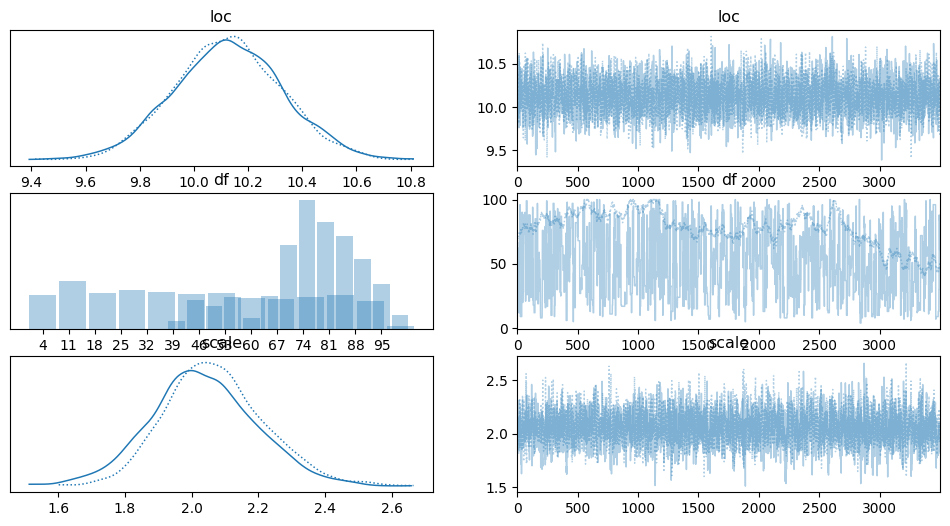

In [2]:
from scipy import stats;
import numpy as np;
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# From this step, we are trying to sep the "true value", in our daily life,
#we don't have access to the true parameter value used to generate our data,
#Because the process of generatinf is too complex.

mu_0, sigma_0 = 0, 10
n, loc_true, scale_true, df_true = 105, 10, 2, 20

# We are creating random samples from distriburion based on the parameters we just generated.
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# The next step, we can define all of the components in our Bayesian model,
#such as piors, likelihood abd posterior.
with pm.Model() as model:
    # This step is to define our prior based on professor's lec help
    loc = pm.Normal('loc', mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    # This step is to set up the likelihood based on PYMC tutorial
    x_obs = pm.StudentT('x_obs', mu=loc, lam=1/scale**2, nu=df, observed=x)

    # In our setting, there will be 3500 samples drawn in this sample,
    #And I am discarting 1000 tuning samples.
    trace = pm.sample(draws=3500, tune=1000, target_accept=0.95)

# For this step, we can analyse the posterior samples in our model,
#We can also see the demonstration of the MCMC behaviour based on our trace.
az.plot_trace(trace)
az.summary(trace, round_to=2)

# Then, we can know how the parameters we defined above estaimated our Bayesian Model
#By having the effective sample size, we know how much posterior are independent, this
#Will provide a more reliable estimates
df_summary = az.summary(trace, var_names=['df'], round_to=2)
df_ess = df_summary['ess_bulk']  # Effective sample size for the df parameter
print(f"Effective sample size for df parameter: {df_ess}")


In [4]:
#All of the code are based on professor's instructions
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})


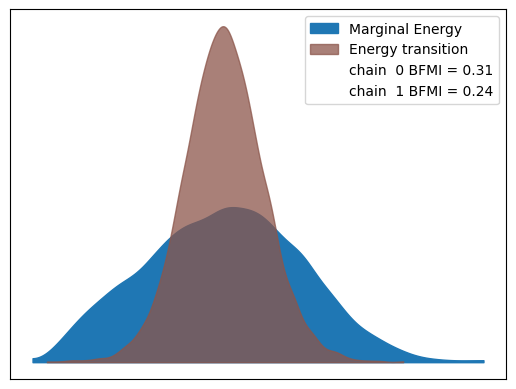

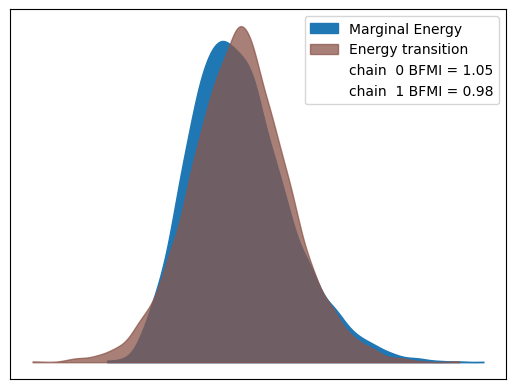

In [5]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Based on the first plot, which is the centered plot, we can see a low value of the BFMI(Baysian Fraction of Misssing Information). This can be seen more clearly within the range of 0.31 and 0.24. This implies the discrepancy exist, and because of this, it will make the process of sampling efficiency more difficult.
It also brings "centered" parameterization more challenging for the HMC(Hamiltonian Monte Carlo) algorithm to explore in the posterior disribution.
For the second plot, it has a different performance. We can see the BFMI value are 1.05 and 0.98 which brings us a lot closer into 1, this can imply that there is a better alignment between the energy trasition and overall energy disrtibution. ALthough this model is considered as "uncentered", however, we do see a much more effective performance of posterior disribution. On some level, it macthed with the definition of the benefit of having a "uncentered" model.